Build ML model

Goal: predict game result (win or lose) based on shot positions

Step 1. predict made_shot% based on shot position (classification),
then use the made% to input to step 2

Step 2. predict player's score based on made% (regression), using the
prediction fron step 1 predict player score and transfer prediction to 
step 3

Step 3. predict team's score based on player's score (regression, requires a calculation of player's contribution to team's performance), based on 
the prediction of step 2 make team score predictation and transfer to 
step 4

Step 4. predict win or lose based on team's score (classification), based 
on predictions from both step 2 and step 3 make win/loss prediction

In [1]:
import sqlite3
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_columns', 999)
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [2]:
conn = sqlite3.connect('shotcharts.db')

df = pd.read_sql_query('SELECT * FROM shotcharts', conn)
df.tail()

,id,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
181930,181930,0021900088,538,2544,LeBron James,1610612747,Los Angeles Lakers,4,9,3,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,18,-168,69,1,0,20191103,SAS,LAL
181931,181931,0021900088,553,2544,LeBron James,1610612747,Los Angeles Lakers,4,8,14,Missed Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,232,1,1,0,20191103,SAS,LAL
181932,181932,0021900088,620,2544,LeBron James,1610612747,Los Angeles Lakers,4,4,21,Missed Shot,Pullup Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-185,181,1,0,20191103,SAS,LAL
181933,181933,0021900088,639,2544,LeBron James,1610612747,Los Angeles Lakers,4,2,45,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-190,-13,1,0,20191103,SAS,LAL
181934,181934,0021900088,661,2544,LeBron James,1610612747,Los Angeles Lakers,4,0,41,Missed Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-201,178,1,0,20191103,SAS,LAL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181935 entries, 0 to 181934
Data columns (total 24 columns):
id                     181935 non-null int64
GAME_ID                181935 non-null object
GAME_EVENT_ID          181935 non-null int64
PLAYER_ID              181935 non-null int64
PLAYER_NAME            181935 non-null object
TEAM_ID                181935 non-null int64
TEAM_NAME              181935 non-null object
PERIOD                 181935 non-null int64
MINUTES_REMAINING      181935 non-null int64
SECONDS_REMAINING      181935 non-null int64
EVENT_TYPE             181935 non-null object
ACTION_TYPE            181935 non-null object
SHOT_TYPE              181935 non-null object
SHOT_ZONE_BASIC        181935 non-null object
SHOT_ZONE_AREA         181935 non-null object
SHOT_ZONE_RANGE        181935 non-null object
SHOT_DISTANCE          181935 non-null int64
LOC_X                  181935 non-null int64
LOC_Y                  181935 non-null int64
SHOT_ATTEMPTED_FLAG    18

In [5]:
df.isnull().values.any()

False

In [7]:
df.insert(len(df.columns), 'TIME_REMAINING',
         Series(df.MINUTES_REMAINING*60 + df.SECONDS_REMAINING))
# print(df.info())

In [8]:
col = ['TEAM_ID', 'TEAM_NAME', 'GAME_EVENT_ID', 'HTM',
       'VTM', 'GAME_DATE', 'GAME_ID', 'id',
      'EVENT_TYPE', 'TIME_REMAINING', 'PERIOD',
       'MINUTES_REMAINING', 'SECONDS_REMAINING']
df.drop(col, 1, inplace=True)

In [9]:
df_name = df[['PLAYER_NAME', 'PLAYER_ID']]

In [10]:
s1 = pd.Series(df_name['PLAYER_NAME'].unique())
s2 = pd.Series(df_name['PLAYER_ID'].unique())

In [11]:
df_player_id = pd.concat([s1, s2], axis=1)
print(df_player_id)

                        0        1
0          Victor Oladipo   203506
1      Karl-Anthony Towns  1626157
2            Nikola Jokic   203999
3            Kyrie Irving   202681
4              Al Horford   201143
5          Damian Lillard   203081
6             Rudy Gobert   203497
7          Draymond Green   203110
8           Kawhi Leonard   202695
9             Paul George   202331
10           Jimmy Butler   202710
11            Joel Embiid   203954
12             Chris Paul   101108
13      Russell Westbrook   201566
14  Giannis Antetokounmpo   203507
15          Anthony Davis   203076
16           James Harden   201935
17          Stephen Curry   201939
18           Kevin Durant   201142
19           LeBron James     2544


In [12]:
oladip_df = df.loc[df['PLAYER_ID']==203506]
towns_df = df.loc[df['PLAYER_ID']==1626157]
jokic_df = df.loc[df['PLAYER_ID']==203999]
irving_df = df.loc[df['PLAYER_ID']==202681]
horford_df = df.loc[df['PLAYER_ID']==201143]
lillard_df = df.loc[df['PLAYER_ID']==203081]
gobert_df = df.loc[df['PLAYER_ID']==203497]
green_df = df.loc[df['PLAYER_ID']==203110]
leonard_df = df.loc[df['PLAYER_ID']==202695]
george_df = df.loc[df['PLAYER_ID']==202331]
butler_df = df.loc[df['PLAYER_ID']==202710]
embiid_df = df.loc[df['PLAYER_ID']==203954]
paul_df = df.loc[df['PLAYER_ID']==101108]
westbrook_df = df.loc[df['PLAYER_ID']==201566]
antetokounmpo_df = df.loc[df['PLAYER_ID']==203507]
davis_df = df.loc[df['PLAYER_ID']==203076]
harden_df = df.loc[df['PLAYER_ID']==201935]
curry_df = df.loc[df['PLAYER_ID']==201939]
durant_df = df.loc[df['PLAYER_ID']==201142]
james_df = df.loc[df['PLAYER_ID']==2544]

In [13]:
# Filter and create inital df for the models
col_id= ['PLAYER_ID', 'PLAYER_NAME']
oladip_df.drop(col_id, axis=1, inplace=True)
towns_df.drop(col_id, axis=1, inplace=True)
jokic_df.drop(col_id, axis=1, inplace=True)
irving_df.drop(col_id, axis=1, inplace=True)
horford_df.drop(col_id, axis=1, inplace=True)
lillard_df.drop(col_id, axis=1, inplace=True)
gobert_df.drop(col_id, axis=1, inplace=True)
green_df.drop(col_id, axis=1, inplace=True)
leonard_df.drop(col_id, axis=1, inplace=True)
george_df.drop(col_id, axis=1, inplace=True)
butler_df.drop(col_id, axis=1, inplace=True)
embiid_df.drop(col_id, axis=1, inplace=True)
paul_df.drop(col_id, axis=1, inplace=True)
westbrook_df.drop(col_id, axis=1, inplace=True)
antetokounmpo_df.drop(col_id, axis=1, inplace=True)
davis_df.drop(col_id, axis=1, inplace=True)
harden_df.drop(col_id, axis=1, inplace=True)
curry_df.drop(col_id, axis=1, inplace=True)
durant_df.drop(col_id, axis=1, inplace=True)
james_df.drop(col_id, axis=1, inplace=True)

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
# Create pickle file to share inital df
# oladip_df.to_pickle("DataFrame/oladip_df")
# towns_df.to_pickle("DataFrame/towns_df")
# jokic_df.to_pickle("DataFrame/jokic_df")
# irving_df.to_pickle("DataFrame/irving_df")
# horford_df.to_pickle("DataFrame/horford_df")
# lillard_df.to_pickle("DataFrame/lillard_df")
# gobert_df.to_pickle("DataFrame/gobert_df")
# green_df.to_pickle("DataFrame/green_df")
# leonard_df.to_pickle("DataFrame/leonard_df")
# george_df.to_pickle("DataFrame/george_df")
# butler_df.to_pickle("DataFrame/butler_df")
# embiid_df.to_pickle("DataFrame/embiid_df")
# paul_df.to_pickle("DataFrame/paul_df")
# westbrook_df.to_pickle("DataFrame/westbrook_df")
# antetokounmpo_df.to_pickle("DataFrame/antetokounmpo_df")
# davis_df.to_pickle("DataFrame/davis_df")
# harden_df.to_pickle("DataFrame/harden_df")
# curry_df.to_pickle("DataFrame/curry_df")
# durant_df.to_pickle("DataFrame/durant_df")
# james_df.to_pickle("DataFrame/james_df")

In [15]:
# oladip_df.columns

1. train_test_split to split data into 80/20

2. cross_val_score to estimate the score on new data

3. preprocessing for standard scaler to transform data so that mean value is 0 and std is 1

4. Random_Forest_Classifier: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

5. Decision Tree Classifier: Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed.

6. LinearSVC: Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data.

7. Logistic Regression: a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. 

8. Voting Classifier:  a wrapper for set of different ones that are trained and valuated in parallel in order to exploit the different peculiarities of each algorithm

9. Confusion matrix and accuracy score to see precision and recall

10. SelectFromModel: is to find features and transform and retrain with just the features selected

11. Joblib to save the model

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel


In [17]:
from sklearn.externals import joblib

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
from sklearn.feature_extraction.text import CountVectorizer


def plot_coefficients(classifier, feature_names, top_features=10):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.title('Al Hartford Features')
 plt.savefig("features/'AlHartford'")
 plt.show()


In [19]:
# oladip_df.to_pickle("DataFrame/oladip_df")
# towns_df.to_pickle("DataFrame/towns_df")
# jokic_df.to_pickle("DataFrame/jokic_df")
# irving_df.to_pickle("DataFrame/irving_df")
# horford_df.to_pickle("DataFrame/horford_df")
# lillard_df.to_pickle("DataFrame/lillard_df")
# gobert_df.to_pickle("DataFrame/gobert_df")
# green_df.to_pickle("DataFrame/green_df")
# leonard_df.to_pickle("DataFrame/leonard_df")
# george_df.to_pickle("DataFrame/george_df")
# butler_df.to_pickle("DataFrame/butler_df")
# embiid_df.to_pickle("DataFrame/embiid_df")
# paul_df.to_pickle("DataFrame/paul_df")
# westbrook_df.to_pickle("DataFrame/westbrook_df")
# antetokounmpo_df.to_pickle("DataFrame/antetokounmpo_df")
# davis_df.to_pickle("DataFrame/davis_df")
# harden_df.to_pickle("DataFrame/harden_df")
# curry_df.to_pickle("DataFrame/curry_df")
# durant_df.to_pickle("DataFrame/durant_df")
# james_df.to_pickle("DataFrame/james_df")

In [20]:
y = np.array(james_df['SHOT_MADE_FLAG']).astype(int)
X = james_df.drop('SHOT_MADE_FLAG', 1)



In [21]:
# Print stat for David

X_loc = X[['LOC_X', 'LOC_Y']].copy()

df = (X_loc.mean(axis=0), X_loc.std(axis=0))
df = pd.DataFrame(list(df))
df = df.rename(index={0: 'X_mean',
               1: 'X_std'})
LeBronJames_loc_stat = df.rename(columns={0: 'Loc_X',
                            1: 'Loc_y'})
# print(NikolaJokic_loc_stat)
LeBronJames_loc_stat.to_pickle("player_loc_stat/LeBronJames_loc_stat")

In [22]:
#                         0        1
# 0          VictorOladipo_loc_stat   203506
# 1      Karl_AnthonyTowns_loc_stat   1626157
# 2            NikolaJokic_loc_stat    203999
# 3            KyrieIrving_loc_stat    202681
# 4              AlHorford_loc_stat    201143
# 5          DamianLillard_loc_stat    203081
# 6             RudyGobert_loc_stat    203497
# 7          DraymondGreen_loc_stat    203110
# 8           KawhiLeonard_loc_stat    202695
# 9             PaulGeorge_loc_stat    202331
# 10           JimmyButler_loc_stat    202710
# 11            JoelEmbiid_loc_stat    203954
# 12             ChrisPaul_loc_stat    101108
# 13      RussellWestbrook_loc_stat    201566
# 14  GiannisAntetokounmpo_loc_stat    203507
# 15          AnthonyDavis_loc_stat    203076
# 16           JamesHarden_loc_stat    201935
# 17          StephenCurry_loc_stat    201939
# 18           KevinDurant_loc_stat    201142
# 19           LeBronJames_loc_stat      2544

In [23]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [24]:

A = X_train[['LOC_X', 'LOC_Y']].copy()

scaler = StandardScaler().fit(A)
A_st = scaler.transform(A)

print(A_st.mean(axis=0), A_st.std(axis=0))

X_train.loc[:, 'angle'] = A_st[:,0]/A_st[:,1]


[-1.16710776e-17 -6.24967383e-17] [1. 1.]


C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
B = X_test[['LOC_X', 'LOC_Y']].copy()
B_st = scaler.transform(B)
X_test.loc[:,'angle'] = B_st[:,0]/B_st[:,1]
print(B_st.mean(axis=0), B_st.std(axis=0))

[-0.00429523  0.00193007] [1.00455127 1.00303642]


C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
X_train = X_train.drop('LOC_X', 1)
X_train = X_train.drop('LOC_Y', 1)

In [27]:
X_test = X_test.drop('LOC_X', 1)
X_test = X_test.drop('LOC_Y', 1)

In [28]:
# X_test.info()
# X_test.isnull().values.any()

In [29]:
# Convert columns to numerical values by using pd.get_dummies()
X_train = pd.get_dummies(X_train)

X_test = pd.get_dummies(X_test)

not_in_test = np.setdiff1d(X_train.columns, X_test.columns)
print(not_in_test)

not_in_train = np.setdiff1d(X_test.columns, X_train.columns)
print(not_in_train)

for c in not_in_test:
    X_test[c] = 0
    
X_test = X_test[X_train.columns]

['ACTION_TYPE_Driving Reverse Dunk Shot' 'ACTION_TYPE_Follow Up Dunk Shot'
 'ACTION_TYPE_Hook Bank Shot' 'ACTION_TYPE_Putback Reverse Dunk Shot'
 'ACTION_TYPE_Running Bank Hook Shot'
 'ACTION_TYPE_Running Reverse Dunk Shot'
 'ACTION_TYPE_Running Reverse Layup Shot'
 'ACTION_TYPE_Step Back Bank Jump Shot' 'ACTION_TYPE_Tip Dunk Shot']
[]


In [30]:
cv = CountVectorizer()
cv.fit(X_train)
# print(len(cv.vocabulary_))
# print(cv.get_feature_names())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [33]:
# oladip_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/oladip_df_X")
# towns_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/towns_df_X")
# jokic_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/jokic_df_X")
# irving_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/irving_df_X")
# horford_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/horford_df")
# lillard_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/lillard_df_X")
# gobert_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/gobert_df_X")
# green_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/green_df_X")
# leonard_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/leonard_df_X")
# george_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/george_df_X")
# butler_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/butler_df_X")
# embiid_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/embiid_df")
# paul_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/paul_df")
# westbrook_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/westbrook_df")
# antetokounmpo_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/antetokounmpo_df_X")
# davis_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/davis_df_X")
# harden_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/harden_df_X")
# curry_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/curry_df_X")
# durant_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/durant_df_X")
# james_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/james_df_X")

In [31]:
log_clf = LogisticRegression()
svm_clf = LinearSVC(random_state=42)
decision_tree_clf = DecisionTreeClassifier(random_state=42)
random_forest_clf = RandomForestClassifier(n_estimators=1000, random_state=42)

In [32]:
named_estimators = [
    ('Log_clf', log_clf),
    ('svm_clf', svm_clf),
    ('decision_tree_clf', decision_tree_clf),
    ('Random_forest_clf', random_forest_clf),
]

In [48]:
estimators = [log_clf, svm_clf, decision_tree_clf, random_forest_clf]
for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X_train, y_train)

Training the LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [49]:
voting_clf = VotingClassifier(named_estimators)


In [50]:
voting_clf.fit(X_train, y_train)

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('Log_clf',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm_clf',
                              LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True,...
                                                     class_weight=None,
                                 

In [51]:
voting_clf.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
           verbose=0),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'),
 RandomForestClassifier(bo

In [52]:
voting_clf.score(X_test, y_test)

0.6543759271031998

In [53]:
estimator_score = [estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

In [54]:
estimator_df = pd.DataFrame(estimator_score)
idx_rename = {0:'log_clf', 1:'svm_clf', 2:'extra_tree', 3:'random_forest'}
col_rename = {0: 'accuracy_score'}

estimator_df = estimator_df.rename(index=idx_rename, columns=col_rename)
estimator_df

,accuracy_score
log_clf,0.668998
svm_clf,0.667514
extra_tree,0.608815
random_forest,0.612630


In [55]:
log_scores = cross_val_score(log_clf, X_test, y_test, cv=3, scoring='accuracy')
log_scores.mean()

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6594612596354558

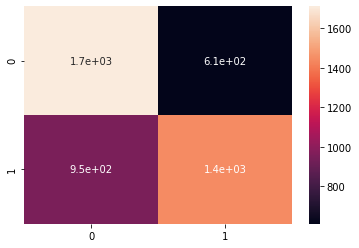

In [56]:
log_clf_pred = log_clf.predict(X_test)
matrix_log = confusion_matrix(y_test, log_clf_pred)
sn.heatmap(matrix_log, annot=True)

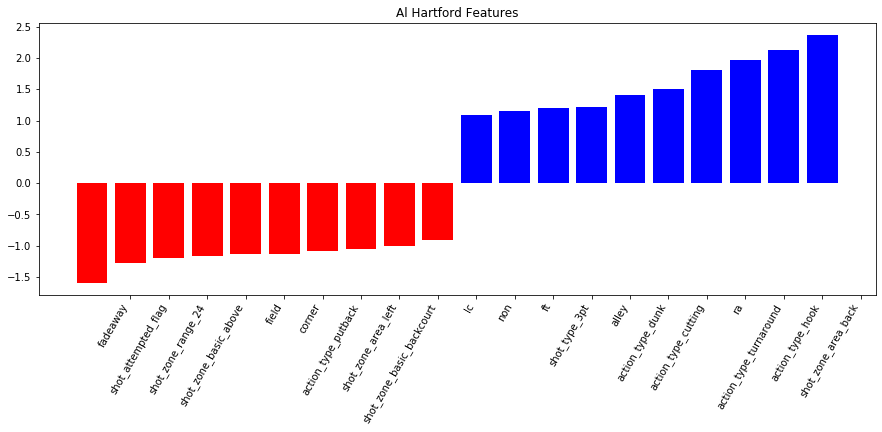

In [57]:
plot_coefficients(log_clf, cv.get_feature_names())

In [58]:
svm_clf_pred = svm_clf.predict(X_test)

In [59]:
svm_scores = cross_val_score(svm_clf, X_test, y_test, cv=3, scoring='accuracy')
svm_scores.mean()

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6202289235319911

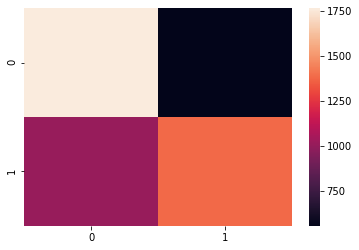

In [60]:
matrix_svm = confusion_matrix(y_test, svm_clf_pred)
sn.heatmap(matrix_svm, annot=False)

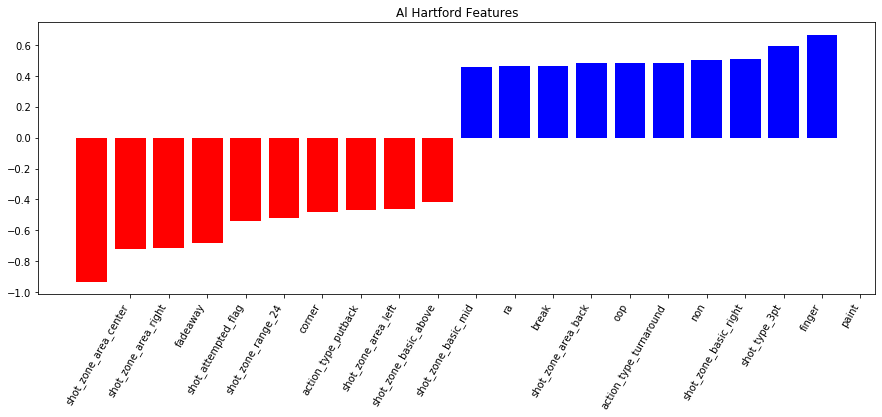

In [61]:
plot_coefficients(svm_clf, cv.get_feature_names())

In [62]:
feature_importance = decision_tree_clf.feature_importances_
# feature_importance = pd.DataFrame(np.std([tree.feature_importances_ for tree in extra_trees_clf.estimators_], axis=0)).reset_index()
# feature_importance = feature_importance.rename(columns={0: 'Feature'})
sorted(zip(feature_importance, X_train), reverse=True)
# feature_importance.sort_values('Feature', ascending=False)

[(0.6329716509857761, 'angle'),
 (0.23655643679966845, 'SHOT_DISTANCE'),
 (0.026473860325783635, 'ACTION_TYPE_Layup Shot'),
 (0.01598912126777727, 'ACTION_TYPE_Jump Shot'),
 (0.006583158821057208, 'SHOT_ZONE_AREA_Right Side(R)'),
 (0.0054129749916641025, 'ACTION_TYPE_Fadeaway Jump Shot'),
 (0.005261574230959114, 'SHOT_ZONE_AREA_Left Side(L)'),
 (0.004870978392705231, 'ACTION_TYPE_Driving Layup Shot'),
 (0.00432340452349482, 'ACTION_TYPE_Running Jump Shot'),
 (0.0028564108619438407, 'ACTION_TYPE_Reverse Layup Shot'),
 (0.0027203796822992533, 'ACTION_TYPE_Tip Shot'),
 (0.002697328176628247, 'ACTION_TYPE_Hook Shot'),
 (0.002652587630171776, 'ACTION_TYPE_Step Back Jump shot'),
 (0.0025224897259325282, 'ACTION_TYPE_Turnaround Fadeaway shot'),
 (0.002445017830600614, 'SHOT_ZONE_AREA_Left Side Center(LC)'),
 (0.002437862159124098, 'SHOT_ZONE_AREA_Right Side Center(RC)'),
 (0.002269512431627684, 'SHOT_ZONE_BASIC_Mid-Range'),
 (0.0021495829169859357, 'ACTION_TYPE_Turnaround Jump Shot'),
 (0.002

In [103]:

# # Plotting a Bar Graph to compare the models 
# plt.bar(X.columns, feature_importance[:5]) 
# plt.xlabel('Feature Labels') 
# plt.ylabel('Feature Importances') 
# plt.title('Comparison of different Feature Importances') 
# plt.show()

In [63]:
decision_tree_scores = cross_val_score(decision_tree_clf, X_test, y_test, cv=3, scoring='accuracy')
decision_tree_scores.mean()

0.5963063384494394

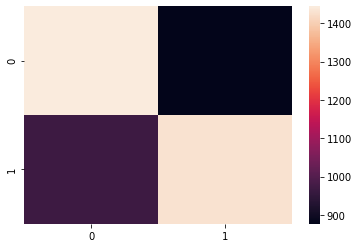

In [65]:
decision_tree_clf_pred = decision_tree_clf.predict(X_test)
matrix_extra = confusion_matrix(y_test, decision_tree_clf_pred)
sn.heatmap(matrix_extra, annot=False)

In [66]:
forest_scores = cross_val_score(random_forest_clf, X_test, y_test, cv=3, scoring='accuracy')
forest_scores.mean()

0.6069027497761427

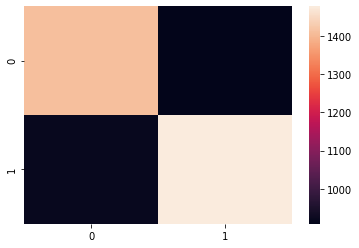

In [67]:
random_forest_clf_pred = random_forest_clf.predict(X_test)
matrix_forest = confusion_matrix(y_test, random_forest_clf_pred)
sn.heatmap(matrix_forest, annot=False)


In [68]:
feature_importance = random_forest_clf.feature_importances_
sorted(zip(feature_importance, X_train), reverse=True)

[(0.6939087509884657, 'angle'),
 (0.09853884715290488, 'SHOT_DISTANCE'),
 (0.03309349397012385, 'ACTION_TYPE_Jump Shot'),
 (0.026001699454112234, 'SHOT_ZONE_BASIC_Restricted Area'),
 (0.017431760508121282, 'SHOT_ZONE_RANGE_Less Than 8 ft.'),
 (0.01622185296396702, 'ACTION_TYPE_Layup Shot'),
 (0.011327494798916277, 'SHOT_ZONE_AREA_Center(C)'),
 (0.0057983950580160456, 'ACTION_TYPE_Driving Layup Shot'),
 (0.004647847618673417, 'ACTION_TYPE_Driving Dunk Shot'),
 (0.004446792788353327, 'SHOT_ZONE_BASIC_Mid-Range'),
 (0.00409215628055262, 'SHOT_TYPE_3PT Field Goal'),
 (0.0040174465152101576, 'ACTION_TYPE_Slam Dunk Shot'),
 (0.003950194362375762, 'SHOT_ZONE_BASIC_In The Paint (Non-RA)'),
 (0.0033931507845008915, 'SHOT_TYPE_2PT Field Goal'),
 (0.0029329448581118605, 'SHOT_ZONE_RANGE_16-24 ft.'),
 (0.002807565469809137, 'ACTION_TYPE_Fadeaway Jump Shot'),
 (0.0027443724135846905, 'ACTION_TYPE_Alley Oop Dunk Shot'),
 (0.0027044033961796062, 'ACTION_TYPE_Turnaround Jump Shot'),
 (0.00269507510787

In [69]:
# Select from model to use a treshold amount for features to use and transform to new train
sfm = SelectFromModel(random_forest_clf, threshold=.015)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=42, verbose=0,
   

In [70]:
for feature_list_index in sfm.get_support(indices=True):
    print(X_train.columns[feature_list_index])

SHOT_DISTANCE
angle
ACTION_TYPE_Jump Shot
ACTION_TYPE_Layup Shot
SHOT_ZONE_BASIC_Restricted Area
SHOT_ZONE_RANGE_Less Than 8 ft.


In [71]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [72]:
clf_important = RandomForestClassifier(n_estimators=1000, random_state=42)
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [73]:
y_important_pred = clf_important.predict(X_important_test)
accuracy_score(y_test, y_important_pred)

0.615172706081797

In [68]:
filename = 'VictorOladipo_new.model'

In [69]:
# joblib.dump(log_clf, filename)
# joblib.dump(svm_clf, filename)
# joblib.dump(extra_trees_clf, filename)
# joblib.dump(random_forest_clf, filename)
joblib.dump(voting_clf, filename)

['VictorOladipo_new.model']

In [70]:
loaded_model = joblib.load('VictorOladipo_new')

In [71]:
result = loaded_model.score(X_test, y_test)

In [72]:
print(result)

0.6404782237403929


In [ ]:
#                0        1
# 0          VictorOladipo   203506
# 1      Karl-AnthonyTowns  1626157
# 2            NikolaJokic   203999
# 3            KyrieIrving   202681
# 4              AlHorford   201143
# 5          DamianLillard   203081
# 6             RudyGobert   203497
# 7          DraymondGreen   203110
# 8           KawhiLeonard   202695
# 9             PaulGeorge   202331
# 10           JimmyButler   202710
# 11            JoelEmbiid   203954
# 12             ChrisPaul   101108
# 13      RussellWestbrook   201566
# 14  GiannisAntetokounmpo   203507
# 15          AnthonyDavis   203076
# 16           JamesHarden   201935
# 17          StephenCurry   201939
# 18           KevinDurant   201142
# 19           LeBronJames     2544